In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# Importing the data set

train = pd.read_csv('dataset/Kaggle_Training_Dataset_v2.csv', low_memory=False)
test = pd.read_csv('dataset/Kaggle_Test_Dataset_v2.csv',low_memory=False)

In [3]:
def process(df, nas=None):
    # Imput missing lines and drop line with problem
    from sklearn.preprocessing import Imputer
    if nas is None:
        nas = {}
        nas['Lead_Time_Median'] = df['lead_time'].median()
        df['lead_time'] = Imputer(strategy='median').fit_transform(
                                    df['lead_time'].values.reshape(-1, 1))
    else:
        df['lead_time'] = df['lead_time'].fillna(nas['Lead_Time_Median'])
    
    df = df.dropna()
    for col in ['perf_6_month_avg', 'perf_12_month_avg']:
        df[col] = Imputer(missing_values=-99).fit_transform(df[col].values.reshape(-1, 1))
    # Convert to binaries
    for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
               'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
        df[col] = (df[col] == 'Yes').astype(int)
    # Normalization    
    from sklearn.preprocessing import normalize
    qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 'sales_3_month', 
                   'sales_6_month', 'sales_9_month',]
    df[qty_related] = normalize(df[qty_related], axis=1)
    # Obsolete parts - optional
    #df = df.loc[(df["forecast_3_month"]>0)|(df["sales_9_month"]>0)]
    return (df, nas)

In [4]:
train, nas = process(train)

C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [5]:
test, nas = process(test, nas=nas)

C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

## Splitting the dataset

In [6]:
X = train.drop(['sku', 'went_on_backorder'], axis=1).values
y = train['went_on_backorder'].values

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_test = test.drop(['sku', 'went_on_backorder'], axis=1).values
y_test = test['went_on_backorder'].values

## Sampling the dataset

In [8]:
# Over Sampling
import imblearn
from imblearn.over_sampling import SMOTE

In [11]:
oversampler = SMOTE()
X_train_smote, y_train_smote = oversampler.fit_sample(X_train, y_train)

In [12]:
print('X_train original shape: ', X_train.shape)
print('X_train new shape: ', X_train_smote.shape)

X_train original shape:  (1350288, 21)
X_train new shape:  (2682508, 21)


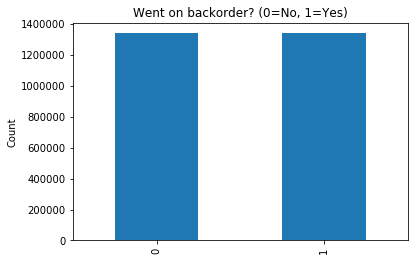

In [13]:
pd.Series(y_train_smote).value_counts().sort_index().plot(kind = 'bar')
plt.ylabel("Count")
plt.title('Went on backorder? (0=No, 1=Yes)')
plt.show()

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
classifier_linear = LogisticRegression(penalty='l1')
classifier_linear.fit(X_train_smote, y_train_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import roc_auc_score

In [19]:
print('Training score: ', roc_auc_score(y_train_smote, classifier_linear.predict_proba(X_train_smote)[:, 1]))
print('Validation score: ', roc_auc_score(y_val, classifier_linear.predict_proba(X_val)[:, 1]))
print('Test score: ', roc_auc_score(y_test, classifier_linear.predict_proba(X_test)[:, 1]))

Training score:  0.922302124946
Validation score:  0.917250492486
Test score:  0.903371253507


### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
classifier_dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)
classifier_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
print('Training score: ', roc_auc_score(y_train, classifier_dt.predict_proba(X_train)[:, 1]))
print('Validation score: ', roc_auc_score(y_val, classifier_dt.predict_proba(X_val)[:, 1]))
print('Test score: ', roc_auc_score(y_test, classifier_dt.predict_proba(X_test)[:, 1]))

Training score:  0.946260516081
Validation score:  0.931832492907
Test score:  0.912461476039


In [ ]:
print('Training score: ', roc_auc_score(y_train, classifier_knn.predict_proba(X_train)[:, 1]))
print('Validation score: ', roc_auc_score(y_val, classifier_knn.predict_proba(X_val)[:, 1]))
print('Test score: ', roc_auc_score(y_test, classifier_knn.predict_proba(X_test)[:, 1]))

In [8]:
# Under Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### Ensemble

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rus_ensemble = make_pipeline(RandomUnderSampler(), RandomForestClassifier(criterion='entropy',n_estimators=10, max_depth=9, min_samples_leaf=5))
rus_ensemble.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('randomundersampler', RandomUnderSampler(random_state=None, ratio='auto', replacement=False,
          return_indices=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_node...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
print('Training score: ', roc_auc_score(y_train, rus_ensemble.predict_proba(X_train)[:, 1]))
print('Validation score: ', roc_auc_score(y_val, rus_ensemble.predict_proba(X_val)[:, 1]))
print('Test score: ', roc_auc_score(y_test, rus_ensemble.predict_proba(X_test)[:, 1]))

Training score:  0.952938296527
Validation score:  0.943810571565
Test score:  0.928783927244


### KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
rus_knn = make_pipeline(RandomUnderSampler(), KNeighborsClassifier(leaf_size=5))
rus_knn.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('randomundersampler', RandomUnderSampler(random_state=None, ratio='auto', replacement=False,
          return_indices=False)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [16]:
print('Training score: ', roc_auc_score(y_train, rus_knn.predict_proba(X_train)[:, 1]))
print('Validation score: ', roc_auc_score(y_val, rus_knn.predict_proba(X_val)[:, 1]))
print('Test score: ', roc_auc_score(y_test, rus_knn.predict_proba(X_test)[:, 1]))

Training score:  0.945755566322
Validation score:  0.928575347056
Test score:  0.882435242088
